In [9]:
%matplotlib inline
import os
import copy
import grid2op
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from grid2op.Episode import EpisodeData

In [92]:
the_fontsize = 8

def _get_all_values(observations, str_function):
    ans = []
    for i in range(1,len(observations)):
        ans.append(getattr(observations[i], str_function))
    return np.array(ans)

def _get_all_action_values(actions, action_key, n_gen=None):
    ans = []
    for i in range(len(actions)):
        act = actions[i].as_dict()
        try:
            spec_act = act[action_key]
        except KeyError:
            spec_act = [0 for i in range(n_gen)]
            
        ans.append(spec_act)
    return np.array(ans)

Read chronics

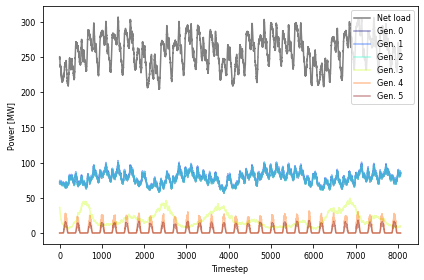

In [44]:
path = 'C:\\Users\\Felipe\\data_grid2op\\l2rpn_case14_sandbox\\chronics\\0000'
load = os.path.join(path, 'load_p.csv.bz2')
gen = os.path.join(path, 'prod_p.csv.bz2')
ld = pd.read_csv(load, sep=';')
gn = pd.read_csv(gen, sep=';')
gn.columns = ['Gen. {}'.format(i) for i in range(6)]
fig, ax = plt.subplots(1)
ld.sum(axis=1).plot(ax=ax, label='Net load', color='gray')
gn.plot(ax=ax, alpha=0.4, cmap=cm.jet)
ax.set_xlabel('Timestep [5 min.]', fontsize=the_fontsize)
ax.set_ylabel('Power [MW]', fontsize=the_fontsize)
ax.legend(fontsize=the_fontsize, loc=1)
plt.xticks(fontsize=the_fontsize)
plt.yticks(fontsize=the_fontsize)
fig.show()
fig.tight_layout()
#fig.savefig(os.path.join(path,'thefig'), dpi=560)
#plt.close(fig)

Actual dispatch vs operator dispatch

In [136]:
case = "_AGC_sandbox_D3QN_CDi242Reward_(AC_ovfMax_acdi)"
episode_studied = "0005"
path_save = 'D:\\ESDA_MSc\\Dissertation\\code_stuff\\cases\\{}'.format(case)
this_episode = EpisodeData.from_disk(path_save, episode_studied)
plays = this_episode.meta['nb_timestep_played']
x = np.arange(plays)
obs = copy.deepcopy(this_episode.observations)
acts = copy.deepcopy(this_episode.actions)
disp_available = obs[-1].gen_redispatchable
disp = np.arange(obs[-1].n_gen)[disp_available]

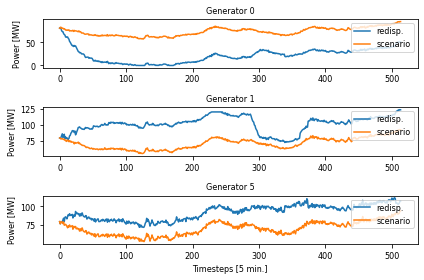

In [137]:
ac_disp = _get_all_values(obs, 'actual_dispatch')
prod_p = _get_all_values(obs, 'prod_p')
ac_disp = ac_disp
prod_p = prod_p
pre_prod_p = prod_p - ac_disp

fig, ax = plt.subplots(3) # 3 dispatchable generators
for ix, d in enumerate(disp):
    ax[ix].set_title('Generator {}'.format(d), fontsize=the_fontsize)
    ax[ix].plot(x, prod_p[:,d], label='redisp.')
    ax[ix].plot(x, pre_prod_p[:,d], label='scenario')
    ax[ix].legend(fontsize=the_fontsize, loc=1)
    ax[ix].set_ylabel('Power [MW]', fontsize=the_fontsize)
    ax[ix].tick_params(axis='x', labelsize=the_fontsize)
    ax[ix].tick_params(axis='y', labelsize=the_fontsize)
ax[ix].set_xlabel('Timesteps [5 min.]', fontsize=the_fontsize)
fig.tight_layout()

Overall flow

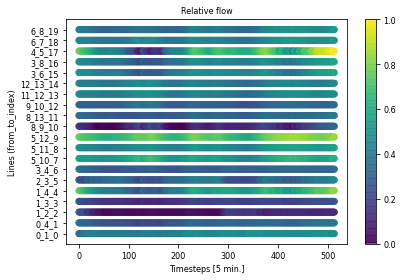

In [138]:
fig, a0 = plt.subplots(1)

a0.set_title('Relative flow', fontsize=the_fontsize)
a0.set_ylabel('Lines (from_to_index)', fontsize=the_fontsize)
a0.set_xlabel('Timesteps [5 min.]', fontsize=the_fontsize)

rho = _get_all_values(obs, 'rho')
for lix in range(rho.shape[1]):
    im = a0.scatter(x, ['{}'.format(obs[-1].name_line[lix])]*plays, c=rho[:,lix], vmin=0, vmax=1, alpha=0.7)
cbar = fig.colorbar(im, ax=a0)
cbar.ax.tick_params(labelsize=the_fontsize)
a0.tick_params(axis='x', labelsize=the_fontsize)
a0.tick_params(axis='y', labelsize=the_fontsize)

fig.tight_layout()
plt.show()

Action analysis graphs

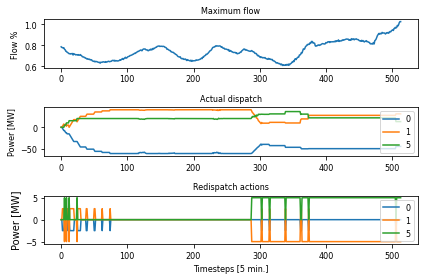

In [143]:
fig, (a0, a1, a2) = plt.subplots(3)

a0.set_title('Maximum flow', fontsize=the_fontsize)
a0.set_ylabel('Flow %', fontsize=the_fontsize)

a1.set_title('Actual dispatch', fontsize=the_fontsize)
a1.set_ylabel('Power [MW]', fontsize=the_fontsize)

a2.set_title('Redispatch actions', fontsize=the_fontsize)
a2.set_ylabel('Power [MW]')
a2.set_xlabel('Timesteps [5 min.]', fontsize=the_fontsize)

#a0.plot(x, np.sum(rho, axis=1)/obs[-1].n_line)
a0.plot(x, np.max(rho, axis=1))
a0.tick_params(axis='x', labelsize=the_fontsize)
a0.tick_params(axis='y', labelsize=the_fontsize)

ac_disp = _get_all_values(obs, 'actual_dispatch')
a1.plot(x, ac_disp[:,disp_available])
a1.tick_params(axis='x', labelsize=the_fontsize)
a1.tick_params(axis='y', labelsize=the_fontsize)
a1.legend(disp, loc=1, fontsize=the_fontsize)

redisp_act = _get_all_action_values(acts, 'redispatch', n_gen=obs[-1].n_gen)
a2.plot(x, redisp_act[:,disp_available])
a2.tick_params(axis='x', labelsize=the_fontsize)
a2.tick_params(axis='y', labelsize=the_fontsize)
a2.legend(disp, loc=1, fontsize=the_fontsize)

fig.tight_layout()
plt.show()

What see DQN as rewards

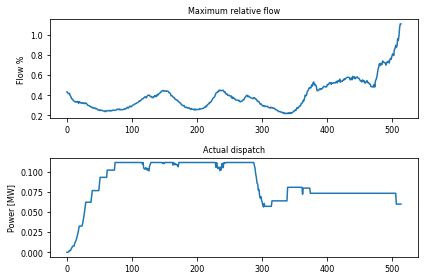

In [156]:
fig, (a0, a1) = plt.subplots(2)

a0.set_title('Maximum relative flow', fontsize=the_fontsize)
a0.set_ylabel('Flow %', fontsize=the_fontsize)

a1.set_title('Actual dispatch', fontsize=the_fontsize)
a1.set_ylabel('Power [MW]', fontsize=the_fontsize)

#a0.plot(x, np.sum(rho, axis=1)/obs[-1].n_line)
a0.plot(x, 50**np.max(rho, axis=1)/50)
a0.tick_params(axis='x', labelsize=the_fontsize)
a0.tick_params(axis='y', labelsize=the_fontsize)

ac_disp = _get_all_values(obs, 'actual_dispatch')
acc_disp = np.abs(ac_disp / obs[-1].gen_pmax)
a1.plot(x, np.sum(acc_disp**2, axis=1)/len(disp))
a1.tick_params(axis='x', labelsize=the_fontsize)
a1.tick_params(axis='y', labelsize=the_fontsize)

fig.tight_layout()
plt.show()